# Example of Creating a dynamic RBA Model

In this notebook you will create simple dynamic models with the dramcom package. You will learn how to use the methods to generate and modify a model, as well as simulating it and getting more insights from the results.

## Monoculture Example

The first step is to import the necessary .py file - the solver suite - that contains all necessary methods and subimports required for the functionality of this package.

In [1]:
import sys

sys.path.append("../../dramcom")

import solver

Note: The above code only works if you have the notebook in the folder as it is in the repository. If you run it from another location, make sure to change the path accordingly.

The first step before even creating the model is to use an appropriate RBA model as generated via the RBApy package <sup>[1]</sup>. There exist several pre-made RBA models that are available on the GitHub site of the Systems Biology Team of the MaiAGE institute at the University of Paris-Saclay <sup>[2]</sup>. The model generating capability of RBApy is described <sup>[3]</sup>, but has not been tested by the author here. If you wish to try to create your own metabolic/RBA model, see the cited article for reference.

In [2]:
import rba
model = rba.RbaModel.from_xml("Escherichia-coli-K12-WT")

The model is now loaded in this environment. Now it gets added to the dynamic model as it is initialized. Let us create the basic scaffold of the model.

In [3]:
dynamic_model = solver.Model(model)

The model has several variables. The .rba_models one is a dictionary containing all RBA models that have been added to the dynamic model.

In [4]:
dynamic_model.rba_models

{'Model': <rba.model.RbaModel at 0x21b2246af88>}

If only one argument is put in, the package automatically uses 'Model' as the default description of the underlying RBA model. If you wish it to be more precise, you can pass a dictionary instead with the desired name as the key (more to that below).

The other variables are empty as of now and are going to be filled as we progress. Let us move on.

----
*The core principle behind this approach is somewhat of a hybrid between a kinetic 'black box' model <sup>[4]</sup> and a metabolic model. A black box model is a type of model where the object of interest contains internal properties that are however ignored - only the external ones are considered. Specifically in the case of microbial organisms, this would be viewing only the nutrients/compounds and energy that get in and out of a cell, disregarding its internal metabolism. A metabolic model like ones used with methods of FBA or RBA instead consider the metabolism as well (in fact, this is their central premise).  
This dynamic model takes into account the metabolism as well, but for constraining it only the external metabolites (of the extracellular space so to say) are used. Constraining the system is the way of 'back-converting' the dynamic rate of change output into a steady-state linear optimization problem. The main assumption behind methods like dFBA <sup>[5]</sup> or dRBA is to use the steady state output of the optimization problem as dynamic rate of change terms. These have to be converted back however for the next iteration during the integration process (which is the solving of this whole dynamic model).*
----

As a next step, the constraints are added to this problem. The constraints are extracellular metabolites that are taken up by the cell and used as substrates for the rest of the metabolism, includng growth. It makes sense to also describe this particular constraining metabolite, although you could assume it to be constant, but limiting. In any case, we will add a single metabolite in this example, namely simple glucose (in its D-form though) to the model.

In [5]:
dynamic_model.add_constr(['M_glc__D'])

The constraints are added in a list, even if it is just one. Also note the particular nomenclature for the metabolite, as is used for the RBA model <sup>[1, *Supplementary Information*]</sup>. Make sure to always check if the constraining metabolite you add actually exists in the model and is written correctly! Otherwise the model will not recognize this metabolite.

In [6]:
dynamic_model.constraints

{'Model': ['M_glc__D']}

The constraints are stored in a dictionary as well with every constraint of a particular model being the value of the model as a key.

Now it is on to the more complicated information - the rate of change description.  

----
*The model automatically builds the right hand side of the system of ordinary differential equations (ODEs) using the ODE information provided. This information has to be provided as a dictionary, with a list of tuples wrapping it for RBA model assignment (see below).  
The keys of this dictionary are the system variables that are undergoing change during the simulation and allows assigning the value correctly, while the value is a list of 2-tuples containing the mathematical descriptions used to build the right hand side. The first value of the tuple is a mathematical operator as a string, the second the numerical value that is used to modify the right hand side.  
During solving, the `.solve()` method will execute the per-time-point function `.drba()` which assembles the correct rate of change. During this process, the cosntraining metabolite is used to constraint the RBA linear programming problem (LP), after which it uses the results of that to construct the preliminary right hand sides and then the information stored in the `.odes()` variable to modify it accordingly.*
----

We will add the variable 'biomass' describing the amount of actual *E. coli* cells and their substrate glucose. The rates of change will be the growth rate and the glucose import flux respectively, with the corresponding modifying values. More information can be added (see below), but we will focus on the simplest example first.

In [7]:
dynamic_model.add_ode({'biomass': [('*', 0.9)], 'R_EX_glc__D_e': [('*', 0.01)]})
dynamic_model.odes

{'Model': {'biomass': [('*', 0.9)], 'R_EX_glc__D_e': [('*', 0.01)]}}

Note the different ID, as right now we are using the reaction to describe the variable.

If we do not like the values, we can simply change these with another call to `.add_ode()` and using an updated container.

In [8]:
dynamic_model.add_ode({'biomass': [('*', 0.8)], 'R_EX_glc__D_e': [('*', 0.01)]})
dynamic_model.odes

{'Model': {'biomass': [('*', 0.8)], 'R_EX_glc__D_e': [('*', 0.01)]}}

Constraints do not really need to be modified, since they are just IDs. However, you can remove any constraints from the model with a simple call to `.remove_constraints()`. For demonstration, let us add ethanol as another metabolite first.

In [9]:
dynamic_model.add_constr(['M_etoh'])
dynamic_model.constraints

{'Model': ['M_glc__D', 'M_etoh']}

Now let us remove it again.

In [10]:
dynamic_model.remove_constraints(['M_etoh'])
dynamic_model.constraints

{'Model': ['M_glc__D']}

We can do the same with ODEs in the model. Again let us add an ODE describing ethanol.

In [11]:
dynamic_model.add_ode({'biomass': [('*', 1)], 'R_EX_glc__D_e': [('*', 0.01)], 'R_EX_etoh_e': [('-', 2.3)]})
dynamic_model.odes

{'Model': {'biomass': [('*', 1)],
  'R_EX_glc__D_e': [('*', 0.01)],
  'R_EX_etoh_e': [('-', 2.3)]}}

And remove it again.

In [12]:
dynamic_model.remove_ode({'Model': 'R_EX_etoh_e'})
dynamic_model.odes

{'Model': {'biomass': [('*', 1)], 'R_EX_glc__D_e': [('*', 0.01)]}}

As you can see, the package provides the basic functionality for constructing and modifying a simple dynamic model. There also exists a method called `.get_model` which returns a string representation of the model structure: the RBA models used, the constraints and the ODEs.

In [13]:
dynamic_model.get_model()

RBA models used:
--------------------------
-Model  

Constraints:
--------------------------
Model:
-M_glc__D


ODEs:
--------------------------
Model:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The variable $Model$ describes the biomass of the organism. Ideally, you want to make sure that the model looks the way you want it to be before starting the computationally intensive simulation. This method will give you that in one quick look.

----
**Before we move on, a warning about the constraints and ODEs: make sure to have the constraints in the same order as they are described in your ODE system! If biomass is to be modeled, it composes the first linear equation, but everything after that are other variables that are put in correspondence with the constraint dictionary. If say for instance glucose is your first constraint and ethanol is your second, but yoor ODE dictionary describes ethanol first, then the `.drba()` method will use the glucose import flux to construct the right hand side for your ethanol differential equation.** 

----
It is now time to finally simulate this system. Due to its simplicity, it should not take too much time (a few minutes on an Acer Notebook with an Intel Core I7-1165G7 and 16 GB of RAM), but it only serves for demonstration purposes as it does not describe anything new or interesting.

In [14]:
import numpy as np
ts = np.linspace(0, 3, 10)  # Desired integration resolution and interval
y0 = [0.1, 10]              #initial values

dynamic_model.solve(y0, ts)

Now we can excess the previously empty `.sol_res` variable containing the result of the call to `solve_ivp()` that can be used to plot the change of *E. coli* cells and glucose over time.

In [15]:
sol = dynamic_model.sol_res
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 11
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.33333333, 0.66666667, 1.        , 1.33333333,
       1.66666667, 2.        , 2.33333333, 2.66666667, 3.        ])
 t_events: None
        y: array([[ 0.1       ,  0.12305885,  0.15181501,  0.18692194,  0.22926531,
         0.28253229,  0.34712809,  0.42560978,  0.5239741 ,  0.64246988],
       [10.        ,  9.62112433,  9.14862551,  8.57176468,  7.87597659,
         7.00062434,  5.93904407,  4.64874309,  3.03006955,  1.07888815]])

In [16]:
import matplotlib
matplotlib.rc('axes', titlesize = 35)     # fontsize of the axes title
matplotlib.rc('axes', labelsize = 20)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize = 15)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize = 15)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize = 15)    # legend fontsize

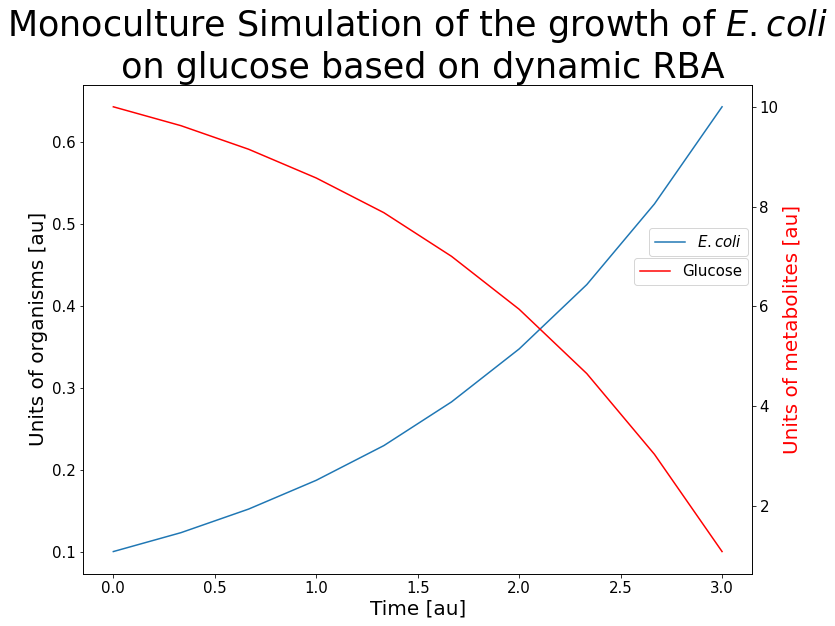

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 9))
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0], label = "$\it{E. coli}$")
ax.legend(loc = (0.845, 0.65))

ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color = 'r', label = "Glucose")
ax2.legend(loc = (0.823, 0.59))


#ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Units of metabolites [au]', color='r')

ax.set(
    title = "Monoculture Simulation of the growth of $\it{E. coli}$ \n on glucose based on dynamic RBA",
    ylabel = "Units of organisms [au]",
    xlabel = "Time [au]" 
)

plt.show()

After viewing the results we might like to know a bit more about the metabolism during simulation though - i.e. about reaction fluxes or enzyme concentration. The latter is especially interesting given that FBA cannot compute any concentrations nor takes into account the molecular machinery needed to carry out the reactions, which makes RBA more realistic.  

However, these informations - although computed for each time step - are lost during the integration, since the SciPy solver only deals with rates of change and requires the corresponding function to output just that. Therefore, the other information needs to be re-calculated, which luckily we can do more easily, as we already know the variable values and do not have to compute them.

This is achieved with a second `results.py` file that is used by the main solver algorithm and returns a second results object that contains additional methods allowing us to extract the necessary information we want. First, let us create this results object by recomputing the steady state outputs.

In [18]:
results = dynamic_model.results()

Now, we can for example see the actual optimal growth rates the organism experienced during the simulation.

In [19]:
results.get_growth()

{'Model': [0.6086182594299316,
  0.6086105108261108,
  0.6085997819900513,
  0.6085848808288574,
  0.6085646152496338,
  0.6085324287414551,
  0.6084811687469482,
  0.6083881855010986,
  0.6081581115722656,
  0.6069713830947876]}

Due to the simplicity of the model, there is not much variation, but you get the idea. We can also further extract the reaction fluxes and enzyme concentrations, though the cells are commented out as the output is quite large (the underlying RBA model has several thousands reactions, each carried out by an enzyme).

In [20]:
#results.get_reactions()

In [21]:
#results.get_enzymes()

So far, there exist no dedicated methods to work with this data more easily. This would be one of the theoretical next steps to improve this package.

## Co-Culture Example

After working through a simple monoculture model, let us walk through the steps again with a simple co-culture model, as one of the premises of the package is to simulate interactions in microbial communities. For this, we need another model.

In [22]:
model2 = rba.RbaModel.from_xml("Escherichia-coli-CO2-fixing")

In [23]:
co_culture = solver.Model({'E. coli wt': model, 'E. coli CO2': model2})

Now we created a dynamic model with two underlying RBA models and named them accordingly. Let us add the constraints and ODEs.

In [24]:
co_culture.add_constr({
    "E. coli wt": ["M_glc__D"],
    "E. coli CO2": ["M_co2"]
})

In [25]:
co_culture.add_ode(
    [("E. coli wt",
      {"biomass": [("*", 1)],
       "R_EX_glc__D_e": [("*", 0.02)]}),
    ("E. coli CO2",
     {"biomass": [("*", 1)],
      "R_EX_co2_e": [("*", 0.01)]})]
)

As told earlier, not only can you specify constant numerical values to modify the right hand side, but also use variable values. What are these values? Well, currently, only the biomass of a certain organism. The biomass automatically increases with the growth rate, but one can further assume that organisms die constantly and thus represent a reduction in the population. Further, the uptake of the external metabolites is considered, but not their export/production by other members of the community which is the basis for a syntrophic interaction. Due to certain intricacies of the RBApy package, export reactions could not be made to work properly as they are supposed to be, so we assume constant death rates and export values for the metabolites.  
For this, the second value of the right hand side tuple has to be another 2-tuple containing the organism one wants to make the term dependent on as the first value, and the numerical value as the second one.

In [26]:
co_culture.add_ode(
    [("E. coli wt", {"biomass": [("*", 1), ("-", ("E. coli wt", 0.1))], 
                     "R_EX_glc__D_e": [("*", 0.012), ("+", ("E. coli CO2", 8))]}),
    ("E. coli CO2", {"biomass": [("*", 1), ("-", ("E. coli CO2", 0.1))],
                    "R_EX_co2_e": [("*", 0.01), ("+", ("E. coli wt", 12))]})]
)

We can get print out the model structure again and you can get a better idea of what the ODE system looks like.

In [27]:
co_culture.get_model()

RBA models used:
--------------------------
-E. coli wt  -E. coli CO2  

Constraints:
--------------------------
E. coli wt:
-M_glc__D

E. coli CO2:
-M_co2


ODEs:
--------------------------
E. coli wt:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

E. coli CO2:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

You can see that for example for the wild-type (wt) *E. coli*, the rate of change increases with the specific growth rate times biomass concentration (= bul growth rate) and decreases with the specific death rate times biomass concentration (= bulk death rate). Now we have a somewhat more realistic system.

Since this model is much more complex, it has not been solved here with the limited hardware of the device it was programmed on. Instead, a computing center of Michigan State University (High Performance Computing Center, HPCC) was used for the simulations - though you could get the same result on a home computer, it would just take a few hours to run.  
Instead, we are going to use an already computed solution that has been stored in a .csv file. In fact, you can store the result of the previous simulation as well. Just use the `.write_results` method and perhaps choose a custom name for the file (as well as a filepath).

In [28]:
dynamic_model.write_results()

With this, a file named 'dRBA_sim.csv' has been created.  

As a last step, us move on to the co-culture simulation.  
Analyzing the file further can just be used by importing it as a pandas dataframe.

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import pandas as pd
cocul_sim = pd.read_csv("example_sim.csv", index_col = 'Unnamed: 0')
cocul_sim

t  E. coli wt    Glucose  E. coli CO2        CO2
0    0.000000    0.100000  10.000000     0.100000  10.000000
1    2.105263    0.118562   9.674822     0.105588  15.048076
2    4.210526    0.143417   9.225562     0.113071  19.971983
3    6.315789    0.180080   8.543446     0.124110  24.662858
4    8.421053    0.234932   7.502656     0.140625  28.994723
5   10.526316    0.315527   5.954049     0.164894  32.818050
6   12.631579    0.433356   3.670714     0.200382  35.905134
7   14.736842    0.605777   0.303648     0.252417  37.894461
8   16.842105    0.639339  -0.000620     0.329541  31.661517
9   18.947368    0.669231  -0.000620     0.443486  22.532617
10  21.052632    0.713292  -0.000620     0.611443   9.866430
11  23.157895    0.777768  -0.000620     0.857204   0.095288
12  25.263158    0.878675  -0.000620     1.241816   0.095288
13  27.368421    1.028336  -0.000620     1.812255   0.095288
14  29.473684    1.265587  -0.000620     2.716544   0.095288
15  31.578947    1.610283  -0.000620     4.030364   0.095288
16  33.684211    2.133764  -0.000620     6.025630   0.095288
17  35.789474    2.937021  -0.000620     9.087267   0.095288
18  37.894737    4.087567  -0.000620    13.472610   0.095288
19  40.000000    5.807814  -0.000620    20.029387   0.095288

And then just plotting it to see the results.

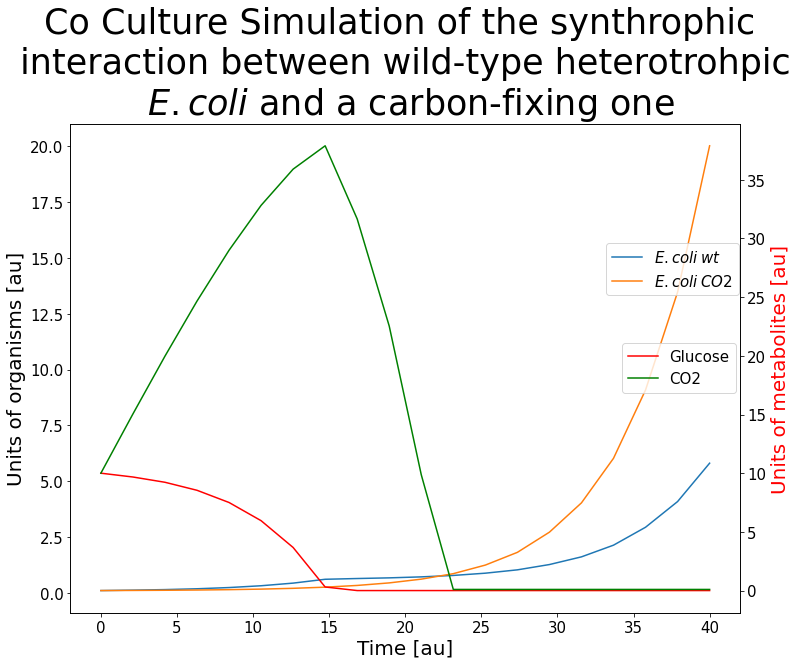

In [31]:
plt.figure(figsize = (12, 9))
ax = plt.subplot(111)
ax.plot(cocul_sim ["t"], cocul_sim ["E. coli wt"], label = "$\it{E. coli \: wt}$")
ax.plot(cocul_sim ["t"], cocul_sim ["E. coli CO2"], label = "$\it{E. coli \: CO2}$")
ax.legend(loc = (0.8, 0.65))

ax2 = plt.twinx(ax)
ax2.plot(cocul_sim ["t"], cocul_sim ["Glucose"], color = 'r', label = "Glucose")
ax2.plot(cocul_sim ["t"], cocul_sim ["CO2"], color = 'g', label = "CO2")
ax2.legend(loc = (0.823, 0.45))

ax2.set_ylabel('Units of metabolites [au]', color='r')

ax.set(
    title = "Co Culture Simulation of the synthrophic \n interaction between wild-type heterotrohpic \n $\it{E. coli}$ and a carbon-fixing one",
    ylabel = "Units of organisms [au]",
    xlabel = "Time [au]" 
)

plt.show()

As can be seen, this simulation is not really realistic, as the organisms continue to grow even after their substrate has run out. It will be necessary to conduct more simulations in the future and further to see how the RBApy base package can be further adjusted to accommodate the needs for a more complicated dynamic model.

## References

[1] Goelzer, A., Muntel, J., Chubukov, V., Jules, M., Prestel, E., Nölker, R., ... & Fromion, V. (2015). Quantitative prediction of genome-wide resource allocation in bacteria. Metabolic engineering, 32, 232-243.  
[2] https://github.com/SysBioInra. Last day of access: 17.12.2021  
[3] Bulović, A., Fischer, S., Dinh, M., Golib, F., Liebermeister, W., Poirier, C., ... & Goelzer, A. (2019). Automated generation of bacterial resource allocation models. Metabolic engineering, 55, 12-22.  
[4] Saadat, N. P., Nies, T., Rousset, Y., & Ebenhöh, O. (2020). Thermodynamic limits and optimality of microbial growth. Entropy, 22(3), 277.  
[5] Mahadevan, R., Edwards, J. S., & Doyle III, F. J. (2002). Dynamic flux balance analysis of diauxic growth
in Escherichia coli. Biophysical journal, 83(3), 1331-1340.  